In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 331M/331M [00:16<00:00, 23.5MB/s]
100% 331M/331M [00:16<00:00, 21.3MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from io import IncrementalNewlineDecoder
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Input

In [ ]:
## LOAD DATASET
BASE_DIR = '/content/UTKFace'

In [ ]:
img_paths = []
img_labels = []
gender_labels = []


## in image name, first number is age and second is gender
for filename in tqdm(os.listdir(BASE_DIR)):
    img_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    img_paths.append(img_path)
    img_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
# dataset creation
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = img_paths, img_labels, gender_labels
df.head()

image  age  gender
0  /content/UTKFace/18_1_0_20170116211949605.jpg....   18       1
1  /content/UTKFace/82_0_0_20170111222624743.jpg....   82       0
2  /content/UTKFace/24_1_4_20170116220449622.jpg....   24       1
3  /content/UTKFace/49_0_2_20170104021434588.jpg....   49       0
4  /content/UTKFace/6_1_0_20170109204905156.jpg.c...    6       1

In [ ]:
# map labels for gender
genderdict = {0: 'Male', 1: 'Female'}

In [ ]:
## Exploratory Data Analysis

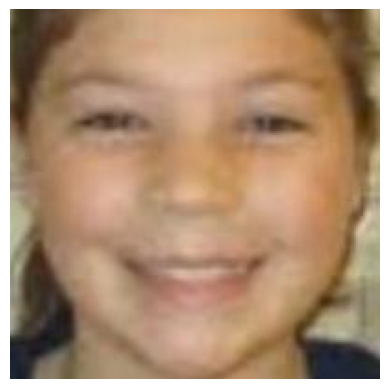

In [ ]:
# we need to convert these images into grayscale and 64x64 (memory issues)
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

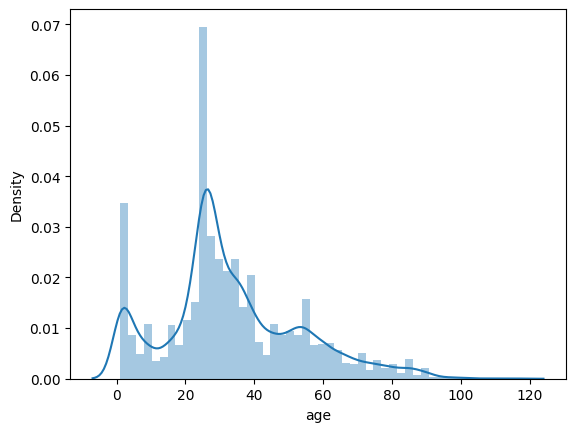

In [ ]:
# class ditribution
sns.distplot(df['age'])

<BarContainer object of 2 artists>

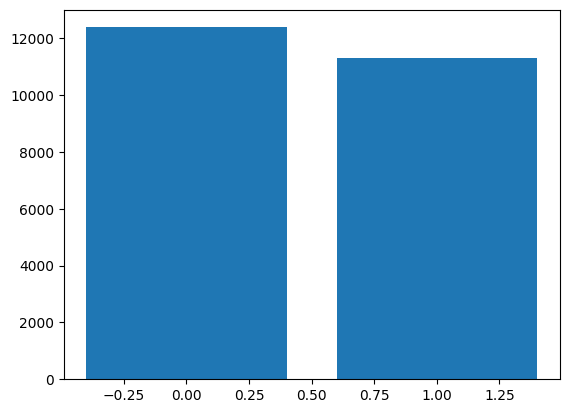

In [ ]:
plt.bar(df['gender'].value_counts().index, df['gender'].value_counts())

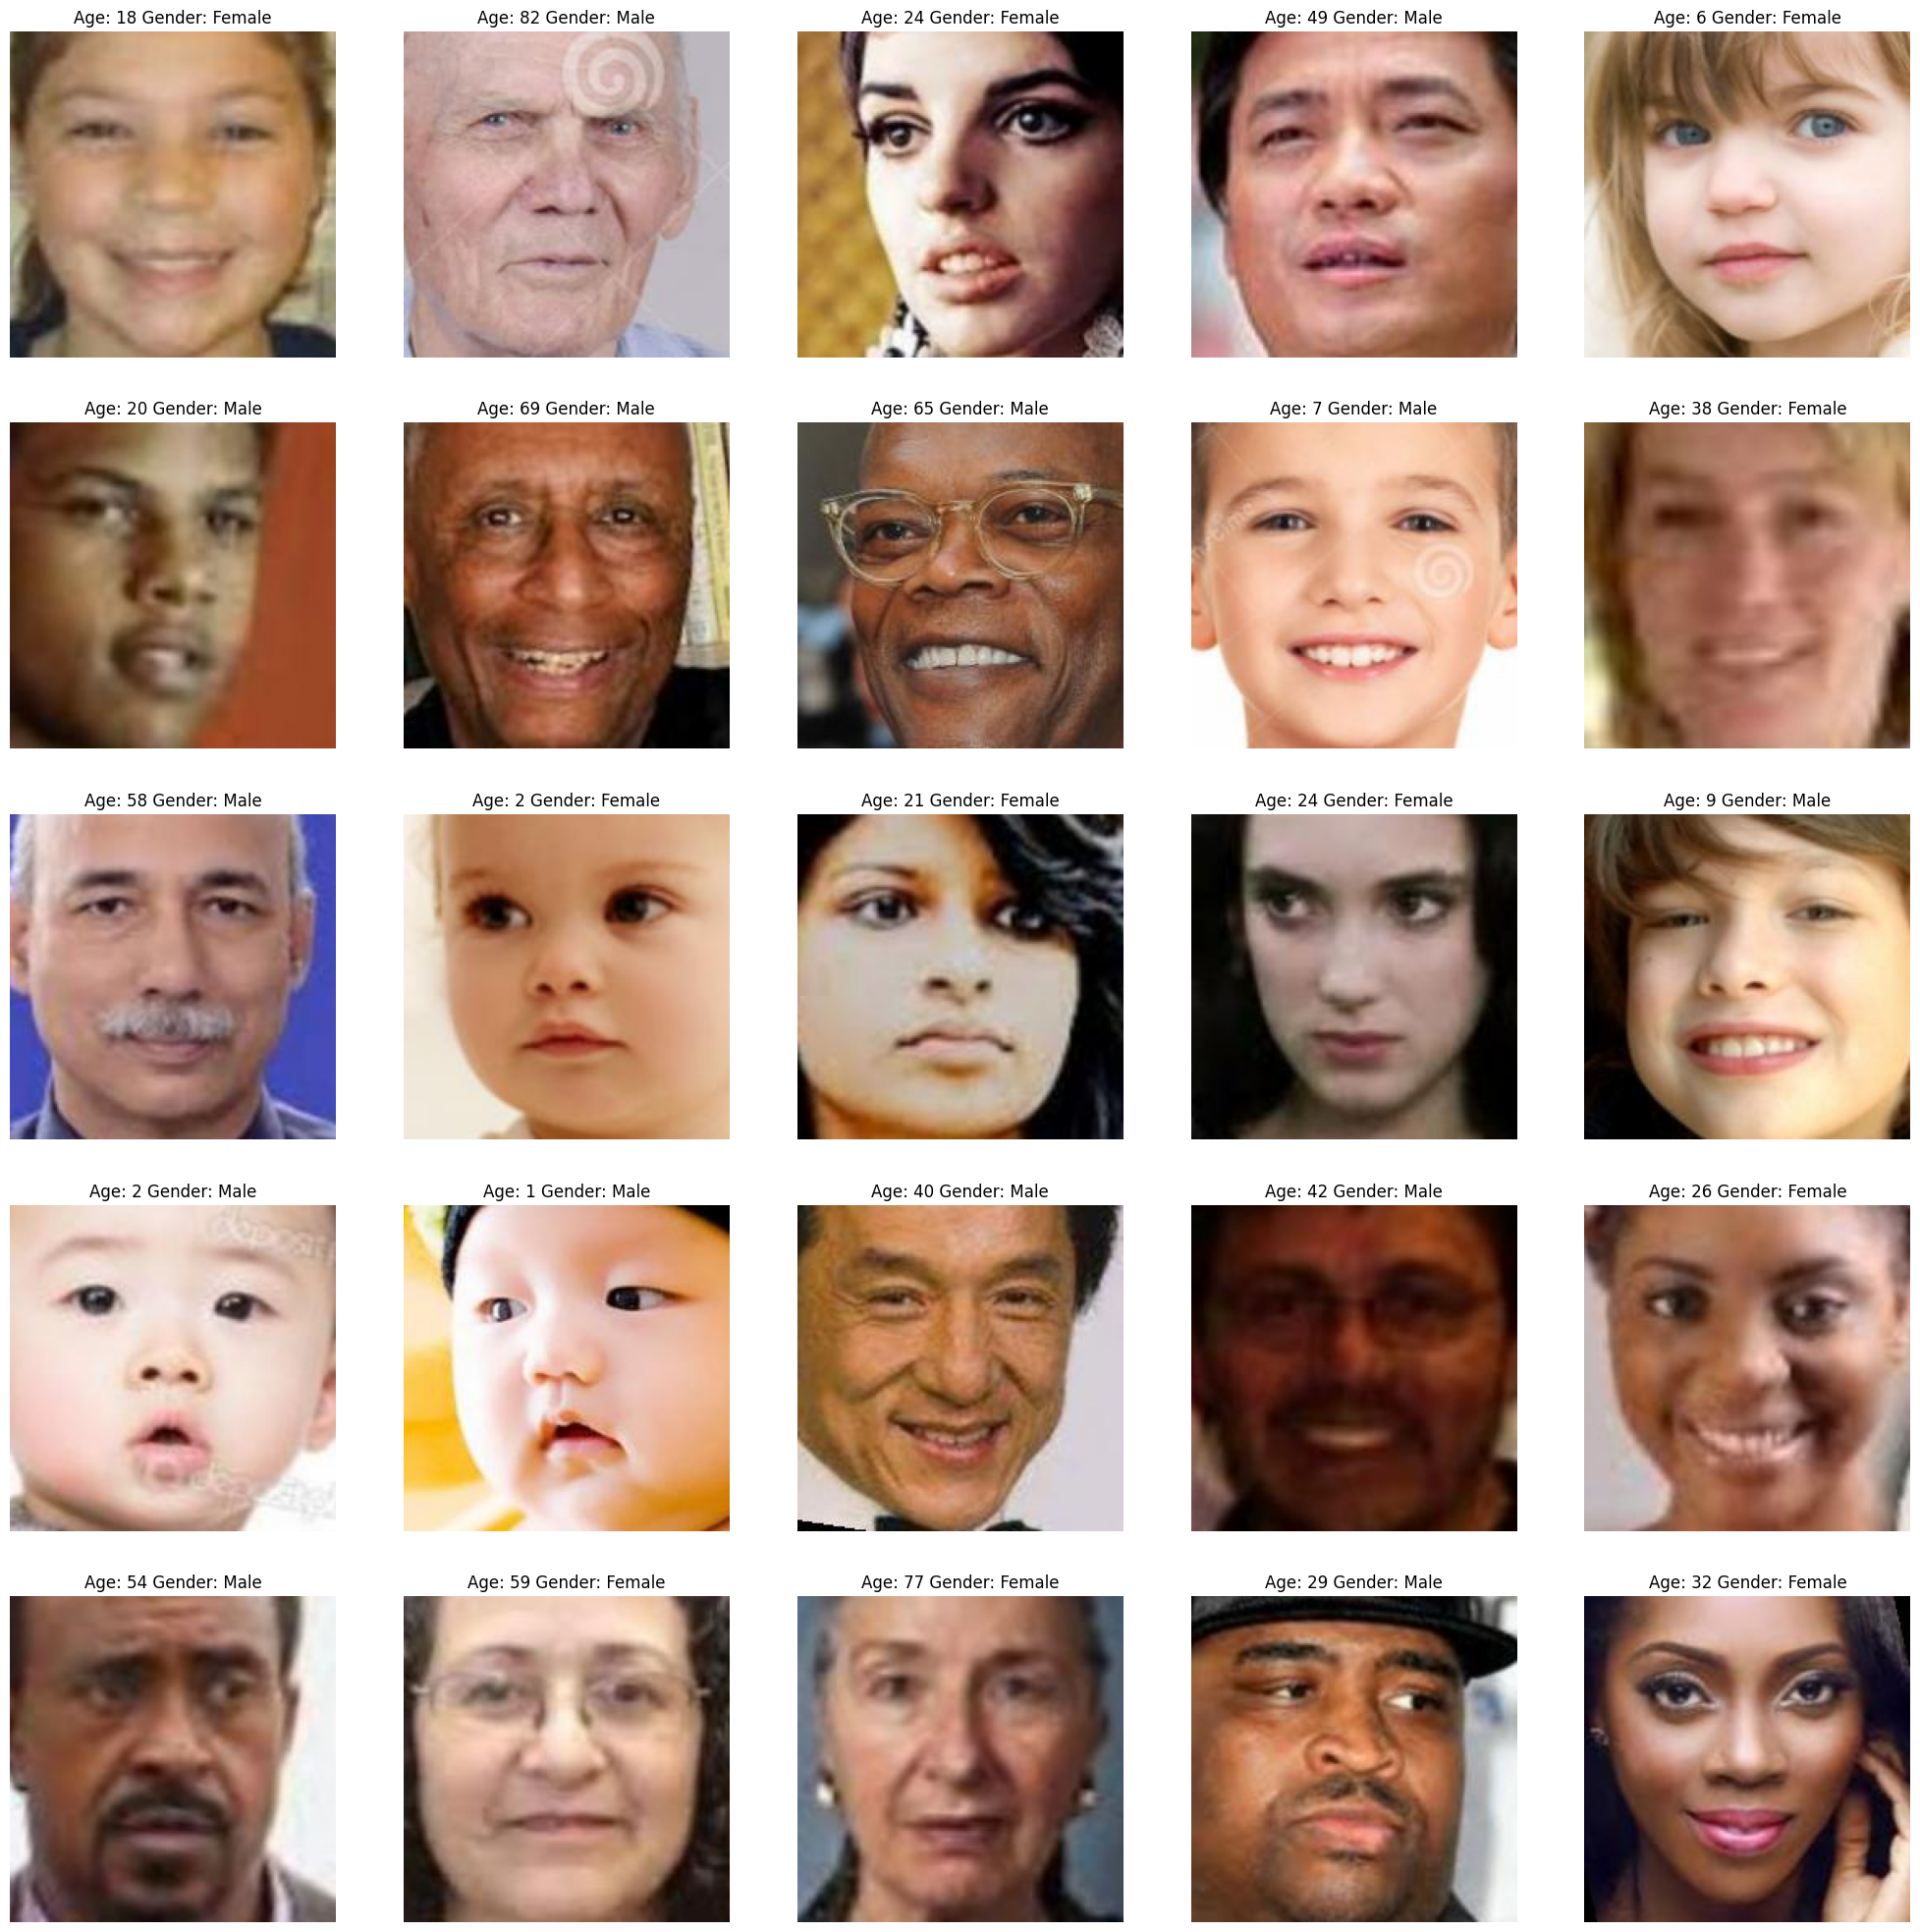

In [ ]:
# display grid of images
plt.figure(figsize= (25,25))
files = df.iloc[0:25] # display first 25 images

for ind, file, age, gender in files.itertuples():
    plt.subplot(5,5,ind+1)  # 5,5 bz 25
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f'Age: {age} Gender: {genderdict[gender]}')
    plt.axis('off')

In [ ]:
## feature extraction
def extract_features(images):
  features = []
  for image in tqdm(images):
    img = load_img(image, color_mode='grayscale')
    img = img.resize((64, 64), Image.LANCZOS)
    img = np.array(img)
    features.append(img)

  features = np.array(features)
  features = features.reshape(len(features), 64,64,1)
  return features

In [ ]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 64, 64, 1)

In [ ]:
# normalization of images
X = X/255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (64,64,1)

## Model Creation

In [ ]:
inputs = Input(shape=input_shape)
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs) # passing inputs to conv1
maxp_1 = MaxPool2D(pool_size=(2,2))(conv_1)  # passing conv1 to maxp1
conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPool2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPool2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPool2D(pool_size=(2,2))(conv_4)

flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(64, activation='relu')(dense_1)

dropout1 = Dropout(0.3)(dense_1)
dropout2 = Dropout(0.3)(dense_2)

# output layers

output_1 = Dense(1, activation='relu', name='age_output')(dropout1)
output_2 = Dense(1, activation='sigmoid', name='gender_output')(dropout2)

model = Model(inputs=inputs, outputs=[output_1, output_2])
model.compile(loss=['mae', 'binary_crossentropy'], optimizer='adam',metrics=['accuracy', 'accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 62, 62, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 31, 31, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 29, 29, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 14, 14, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 12, 12, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 6, 6, 128)      │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 256)      │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 2, 2, 256)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1024)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        262,400 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │         16,448 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 667,010 (2.54 MB)

 Trainable params: 667,010 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

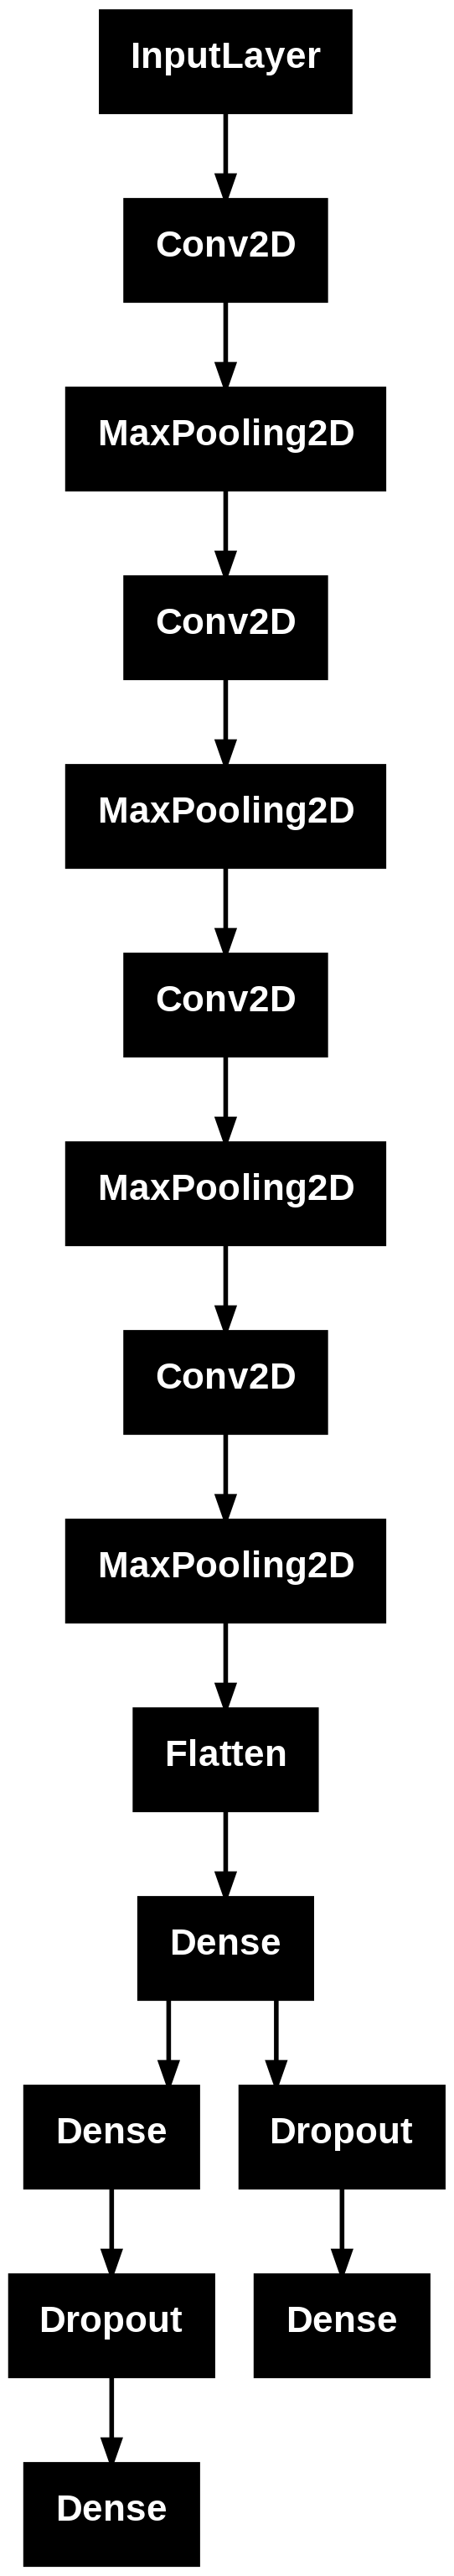

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
history = model.fit(x=X, y=[y_age,y_gender], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - age_output_accuracy: 0.0462 - gender_output_accuracy: 0.4970 - loss: 17.5851 - val_age_output_accuracy: 0.0451 - val_gender_output_accuracy: 0.5312 - val_loss: 14.7658
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - age_output_accuracy: 0.0459 - gender_output_accuracy: 0.5432 - loss: 14.1623 - val_age_output_accuracy: 0.0390 - val_gender_output_accuracy: 0.7024 - val_loss: 11.0048
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - age_output_accuracy: 0.0367 - gender_output_accuracy: 0.6801 - loss: 10.9504 - val_age_output_accuracy: 0.0437 - val_gender_output_accuracy: 0.7212 - val_loss: 9.7993
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - age_output_accuracy: 0.0449 - gender_output_accuracy: 0.7193 - loss: 9.8805 - val_age_output_accuracy: 0.0451 - val_gender_output_accuracy: 0.7623 - val_loss: 10.3576
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - age_output_accuracy: 0.0455 - gender_output_accuracy: 0.74

In [ ]:
import pickle
with open('model.pk', 'wb') as file:
    pickle.dump(model, file)

## plot results

<Figure size 640x480 with 0 Axes>

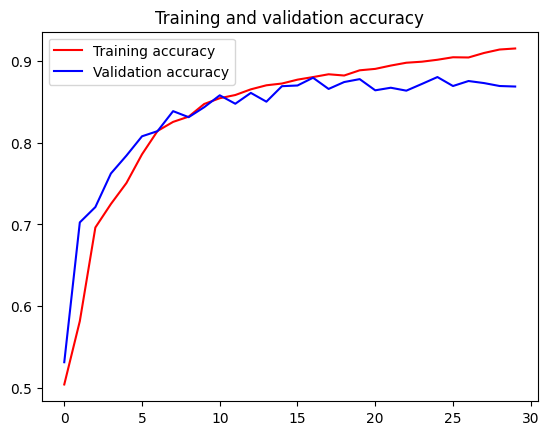

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['gender_output_accuracy']
val_acc = history.history['val_gender_output_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

## Prediction

predicted gender  Female
predicted age  15


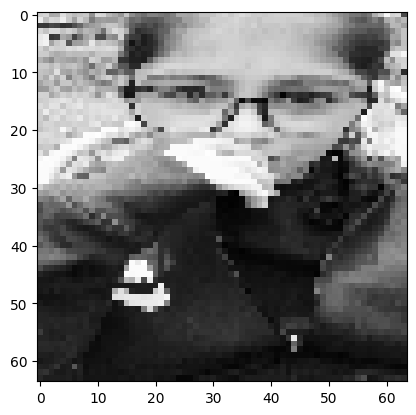

In [ ]:
# image_index = 40
# print('original gender ', genderdict[df['gender'][image_index]])
# print('original age ', df['age'][image_index])
from tensorflow.keras.preprocessing.image import load_img, img_to_array
IMG = '/content/TEST.jpg'
img = load_img(IMG, target_size=(64, 64), color_mode='grayscale')  # Load image in grayscale
img_array = img_to_array(img)  # Convert to array
img_array = img_array / 255.0  # Normalize to [0, 1]
img_array = img_array.reshape(1, 64, 64, 1)  # Reshape for the model
print('predicted gender ', genderdict[round(pred[1][0][0])])
print('predicted age ', round(pred[0][0][0]))

plt.imshow(img_array.reshape(64,64), cmap='gray')

In [ ]:
from tensorflow.keras.models import load_model

# Assuming 'model' is your trained model
model.save('agegender.h5')


In [65]:
model.save('model.keras')